# Object masks in images from prompts with SAM 2

## Set-up

Necessary imports and helper functions for displaying points, boxes, and masks.

In [59]:
import os
import sys
os.environ["PYTORCH_ENABLE_MPS_FALLBACK"] = "1"
sys.path.append(os.path.abspath(os.path.dirname(os.getcwd())))

import cv2
import numpy as np
import torch
import matplotlib.pyplot as plot
from matplotlib import patches
from PIL import Image

from utils.build_sam2 import build_sam2
from sam2.sam2_image_predictor import SAM2ImagePredictor

In [60]:
# select the device for computation
if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")

if device.type == "cuda":
    # use bfloat16 for the entire notebook
    torch.autocast("cuda", dtype=torch.bfloat16).__enter__()
    # turn on tfloat32 for Ampere GPUs (https://pytorch.org/docs/stable/notes/cuda.html#tensorfloat-32-tf32-on-ampere-devices)
    if torch.cuda.get_device_properties(0).major >= 8:
        torch.backends.cuda.matmul.allow_tf32 = True
        torch.backends.cudnn.allow_tf32 = True
elif device.type == "mps":
    print(
        "\nSupport for MPS devices is preliminary. SAM 2 is trained with CUDA and might "
        "give numerically different outputs and sometimes degraded performance on MPS. "
        "See e.g. https://github.com/pytorch/pytorch/issues/84936 for a discussion."
    )


Support for MPS devices is preliminary. SAM 2 is trained with CUDA and might give numerically different outputs and sometimes degraded performance on MPS. See e.g. https://github.com/pytorch/pytorch/issues/84936 for a discussion.


In [61]:
np.random.seed(3)


def show_mask(mask, ax, random_color=False, borders=True):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30 / 255, 144 / 255, 255 / 255, 0.6])
    h, w = mask.shape[-2:]
    mask = mask.astype(np.uint8)
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    if borders:
        contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
        # Try to smooth contours
        contours = [
            cv2.approxPolyDP(contour, epsilon=0.01, closed=True) for contour in contours
        ]
        mask_image = cv2.drawContours(
            mask_image, contours, -1, (1, 1, 1, 0.5), thickness=2
        )
    ax.imshow(mask_image)


def show_points(coords, labels, ax, marker_size=375):
    positive_points = coords[labels == 1]
    negative_points = coords[labels == 0]
    ax.scatter(
        positive_points[:, 0],
        positive_points[:, 1],
        color="green",
        marker="*",
        s=marker_size,
        edgecolor="white",
        linewidth=1.25,
    )
    ax.scatter(
        negative_points[:, 0],
        negative_points[:, 1],
        color="red",
        marker="*",
        s=marker_size,
        edgecolor="white",
        linewidth=1.25,
    )


def show_box(box, ax):
    x, y = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(
        patches.Rectangle(
            (x, y), w, h, edgecolor="green", facecolor=(0, 0, 0, 0), lw=2
        )
    )


def show_masks(
    image,
    masks,
    scores,
    point_coords=None,
    point_labels=None,
    box=None,
    borders=True,
):
    for i, (mask, score) in enumerate(zip(masks, scores)):
        plot.figure(figsize=(10, 10))
        plot.imshow(image)
        show_mask(mask, plot.gca(), borders=borders)
        if point_coords is not None:
            assert point_labels is not None
            show_points(point_coords, point_labels, plot.gca())
        if box is not None:
            # boxes
            show_box(box, plot.gca())
        if len(scores) > 1:
            plot.title(f"Mask {i+1}, Score: {score:.3f}", fontsize=18)
        plot.axis("off")
        plot.show()

## Example image

In [62]:
image = Image.open("../datas/images/truck.jpg")
image = np.array(image.convert("RGB"))

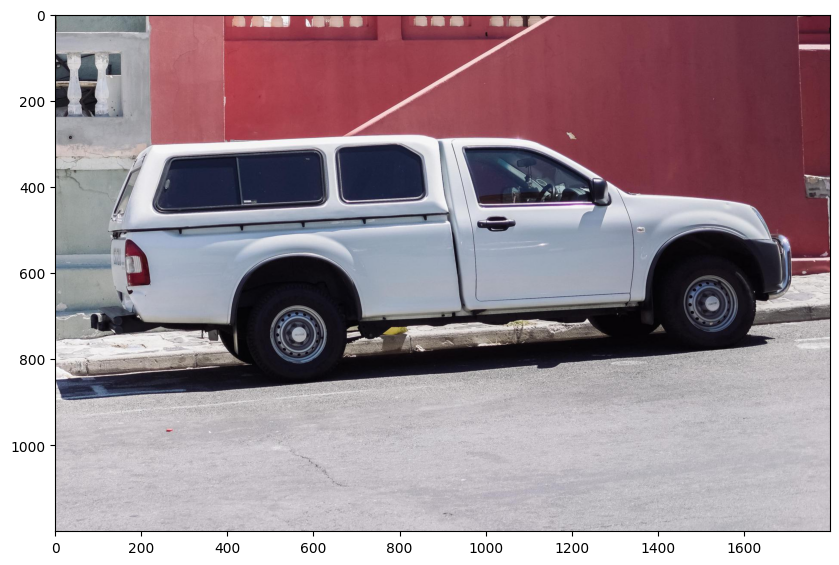

In [63]:
plot.figure(figsize=(10, 10))
plot.imshow(image)
plot.axis("on")
plot.show()

## Selecting objects with SAM 2

First, load the SAM 2 model and predictor. Change the path below to point to the SAM 2 checkpoint. Running on CUDA and using the default model are recommended for best results.

In [86]:
sam2_checkpoint = "../sam2/checkpoints/sam2_hiera_large.pt"
model_config = "../sam2/configs/sam2_hiera_l.yaml"

sam2_model = build_sam2(model_config, sam2_checkpoint, device=device)
sam2_predictor = SAM2ImagePredictor(sam2_model)

Process the image to produce an image embedding by calling `SAM2ImagePredictor.set_image`. `SAM2ImagePredictor` remembers this embedding and will use it for subsequent mask prediction.

In [65]:
sam2_predictor.set_image(image)

To select the truck, choose a point on it. Points are input to the model in (x,y) format and come with labels 1 (foreground point) or 0 (background point). Multiple points can be input; here we use only one. The chosen point will be shown as a star on the image.

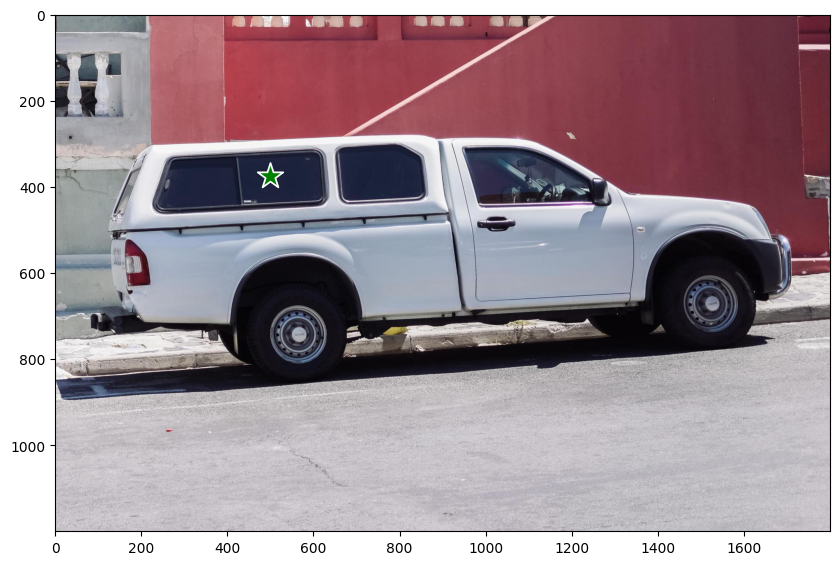

torch.Size([1, 256, 64, 64])

In [66]:
point_coord = np.array([[500, 375]])
point_label = np.array([1])
plot.figure(figsize=(10, 10))
plot.imshow(image)
show_points(point_coord, point_label, plot.gca())
plot.axis("on")
plot.show()
if sam2_predictor._features is not None:
    display(sam2_predictor._features["image_embed"].shape)

Predict with `SAM2ImagePredictor.predict`. The model returns masks, quality predictions for those masks, and low resolution mask logits that can be passed to the next iteration of prediction.

In [67]:
masks, scores, logits = sam2_predictor.predict(
    point_coords=point_coord,
    point_labels=point_label,
    multimask_output=True,
)
sorted_ind = np.argsort(scores)[::-1]
masks = masks[sorted_ind]
scores = scores[sorted_ind]
logits = logits[sorted_ind]

With `multimask_output=True` (the default setting), SAM 2 outputs 3 masks, where `scores` gives the model's own estimation of the quality of these masks. This setting is intended for ambiguous input prompts, and helps the model disambiguate different objects consistent with the prompt. When `False`, it will return a single mask. For ambiguous prompts such as a single point, it is recommended to use `multimask_output=True` even if only a single mask is desired; the best single mask can be chosen by picking the one with the highest score returned in `scores`. This will often result in a better mask.

'num_predicted x H x W - (3, 1200, 1800)'

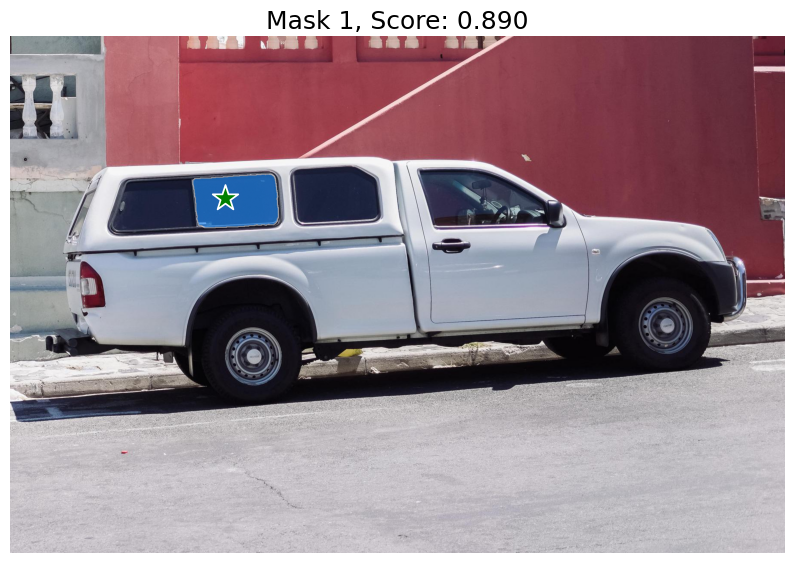

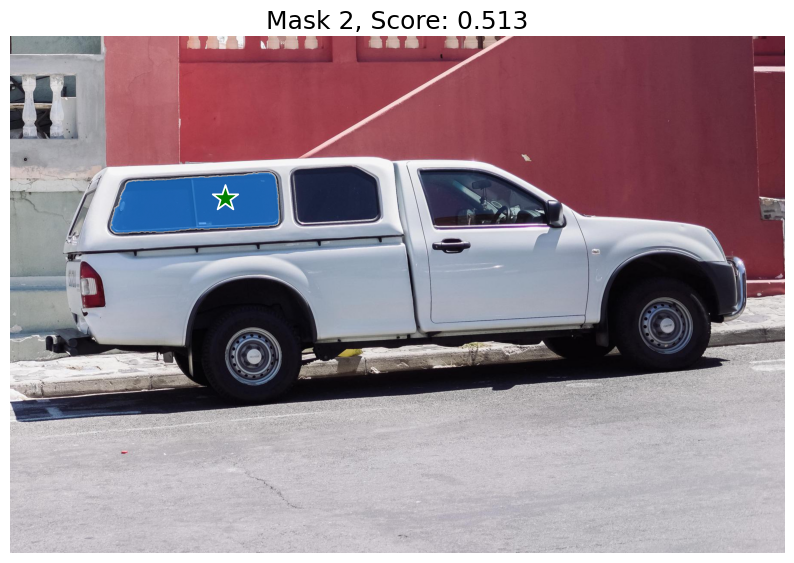

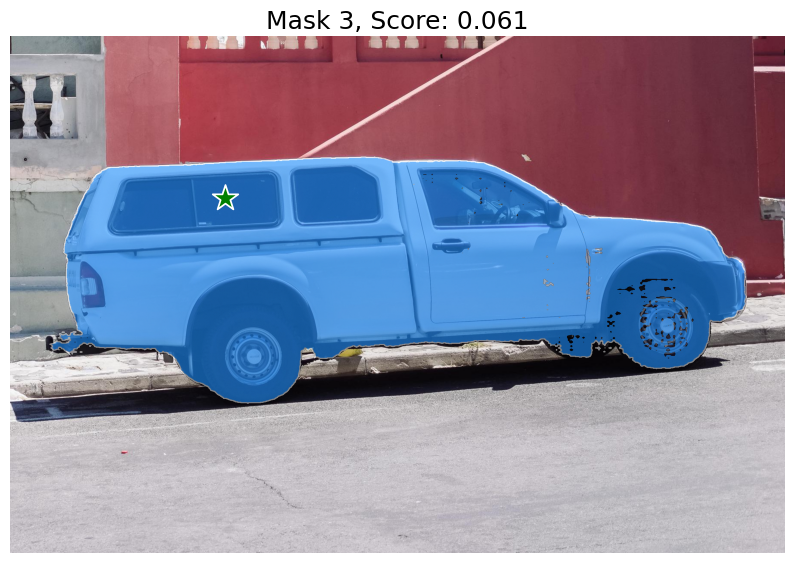

In [68]:
display(f"num_predicted x H x W - {masks.shape}")
show_masks(
    image,
    masks,
    scores,
    point_coords=point_coord,
    point_labels=point_label,
    borders=True,
)

## Specifying a specific object with additional points

The single input point is ambiguous, and the model has returned multiple objects consistent with it. To obtain a single object, multiple points can be provided. If available, a mask from a previous iteration can also be supplied to the model to aid in prediction. When specifying a single object with multiple prompts, a single mask can be requested by setting `multimask_output=False`.

In [69]:
point_coord = np.array([[500, 375], [1125, 625]])
point_label = np.array([1, 1])
mask_input = logits[np.argmax(scores), :, :]
masks, scores, _ = sam2_predictor.predict(
    point_coords=point_coord,
    point_labels=point_label,
    mask_input=mask_input[None, :, :],
    multimask_output=False,
)

'num_predicted x H x W - (1, 1200, 1800)'

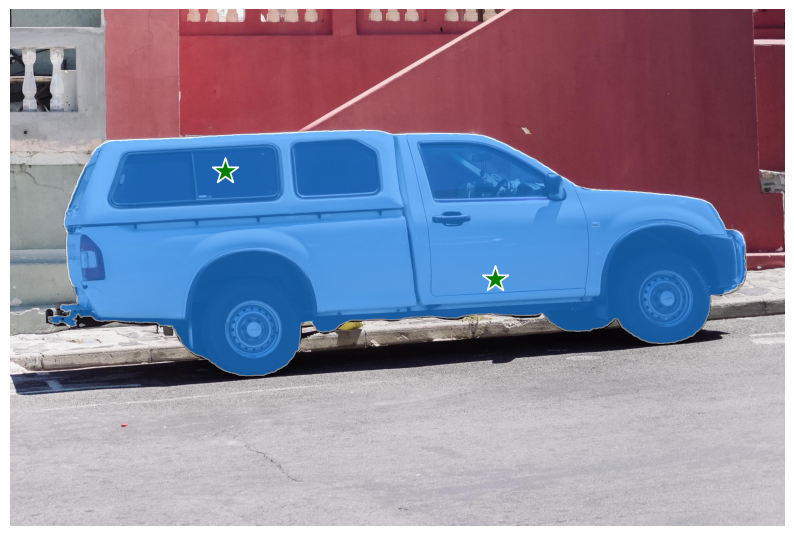

In [70]:
display(f"num_predicted x H x W - {masks.shape}")
show_masks(image, masks, scores, point_coords=point_coord, point_labels=point_label)

To exclude the car and specify just the window, a background point (with label 0, here shown in red) can be supplied.

In [71]:
point_coord = np.array([[500, 375], [1125, 625]])
point_label = np.array([1, 0])
mask_input = logits[np.argmax(scores), :, :]
masks, scores, _ = sam2_predictor.predict(
    point_coords=point_coord,
    point_labels=point_label,
    mask_input=mask_input[None, :, :],
    multimask_output=False,
)

'num_predicted x H x W - (1, 1200, 1800)'

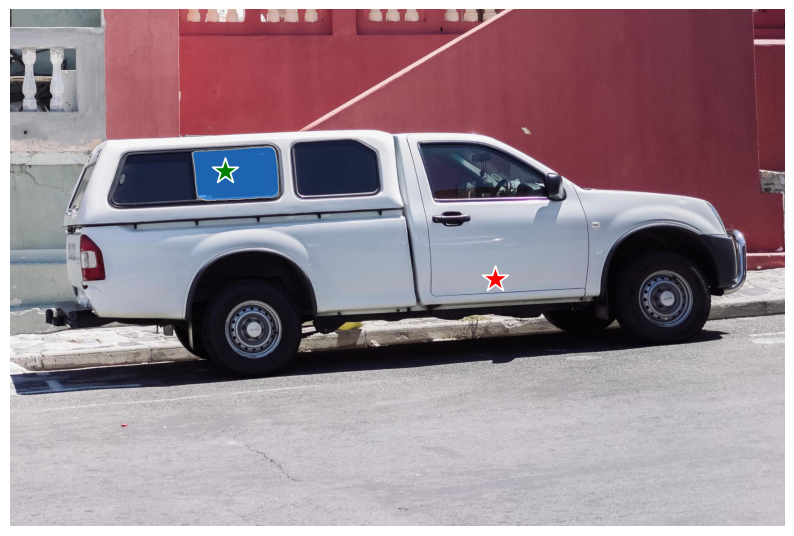

In [72]:
display(f"num_predicted x H x W - {masks.shape}")
show_masks(image, masks, scores, point_coords=point_coord, point_labels=point_label)

## Specifying a specific object with a box

The model can also take a box as input, provided in xyxy format.

In [73]:
box = np.array([425, 600, 700, 875])
masks, scores, _ = sam2_predictor.predict(
    point_coords=None,
    point_labels=None,
    box=box[None, :],
    multimask_output=False,
)

'num_predicted x H x W - (1, 1200, 1800)'

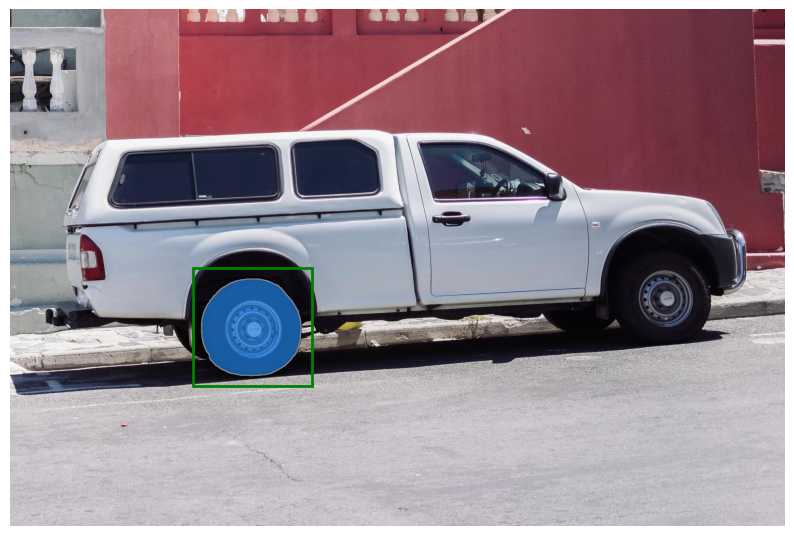

In [74]:
display(f"num_predicted x H x W - {masks.shape}")
show_masks(image, masks, scores, box=box)

## Combining points and boxes

Points and boxes may be combined, just by including both types of prompts to the predictor. Here this can be used to select just the trucks's tire, instead of the entire wheel.

In [75]:
point_coord = np.array([[575, 750]])
point_label = np.array([0])
box = np.array([425, 600, 700, 875])
masks, scores, logits = sam2_predictor.predict(
    point_coords=point_coord,
    point_labels=point_label,
    box=box,
    multimask_output=False,
)

'num_predicted x H x W - (1, 1200, 1800)'

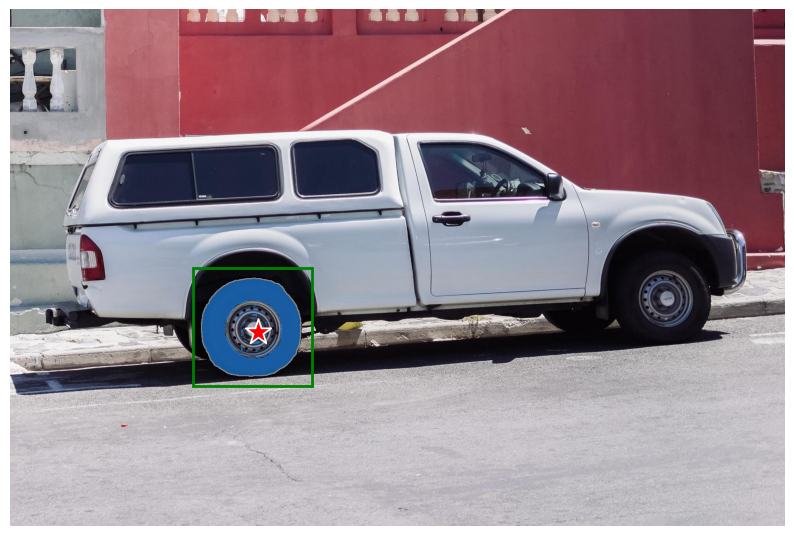

In [76]:
display(f"num_predicted x H x W - {masks.shape}")
show_masks(
    image,
    masks,
    scores,
    point_coords=point_coord,
    point_labels=point_label,
    box=box,
)

## Batched prompt inputs

`SAM2ImagePredictor` can take multiple input prompts for the same image, using `predict` method. For example, imagine we have several box outputs from an object detector.

In [77]:
box = np.array(
    [
        [75, 275, 1725, 850],
        [425, 600, 700, 875],
        [1375, 550, 1650, 800],
        [1240, 675, 1400, 750],
    ]
)
masks, scores, _ = sam2_predictor.predict(
    point_coords=None,
    point_labels=None,
    box=box,
    multimask_output=False,
)

'batch_size x num_predicted_masks_per_input x H x W - (4, 1, 1200, 1800)'

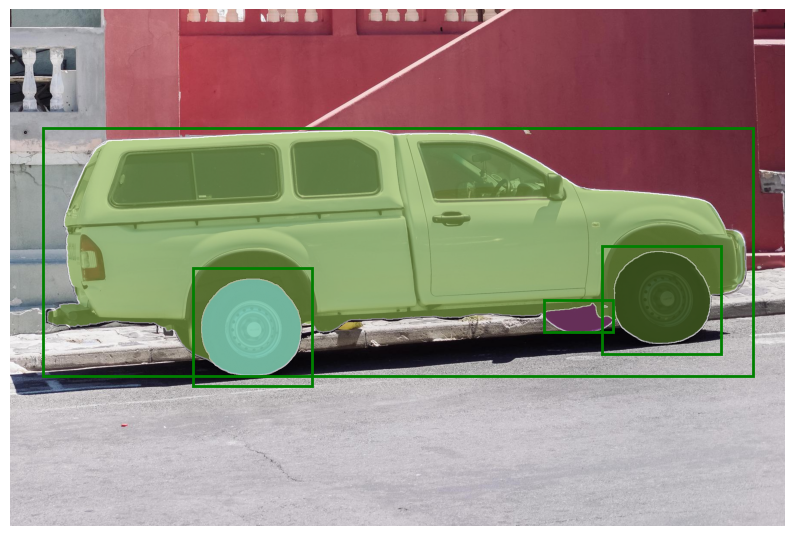

In [78]:
display(f"batch_size x num_predicted_masks_per_input x H x W - {masks.shape}")
plot.figure(figsize=(10, 10))
plot.imshow(image)
for mask in masks:
    show_mask(mask.squeeze(0), plot.gca(), random_color=True)
for box in box:
    show_box(box, plot.gca())
plot.axis("off")
plot.show()

## End-to-end batched inference
If all prompts are available in advance, it is possible to run SAM 2 directly in an end-to-end fashion. This also allows batching over images.

In [79]:
image1 = Image.open("../datas/images/truck.jpg")
image1 = np.array(image1.convert("RGB"))
image1_boxes = np.array(
    [
        [75, 275, 1725, 850],
        [425, 600, 700, 875],
        [1375, 550, 1650, 800],
        [1240, 675, 1400, 750],
    ]
)

image2 = Image.open("../datas/images/groceries.jpg")
image2 = np.array(image2.convert("RGB"))
image2_boxes = np.array(
    [
        [450, 170, 520, 350],
        [350, 190, 450, 350],
        [500, 170, 580, 350],
        [580, 170, 640, 350],
    ]
)

image_batch = [image1, image2]
boxes_batch = [image1_boxes, image2_boxes]

In [80]:
sam2_predictor.set_image_batch(image_batch)

In [81]:
masks_batch, scores_batch, _ = sam2_predictor.predict_batch(box_batch=boxes_batch, multimask_output=False)

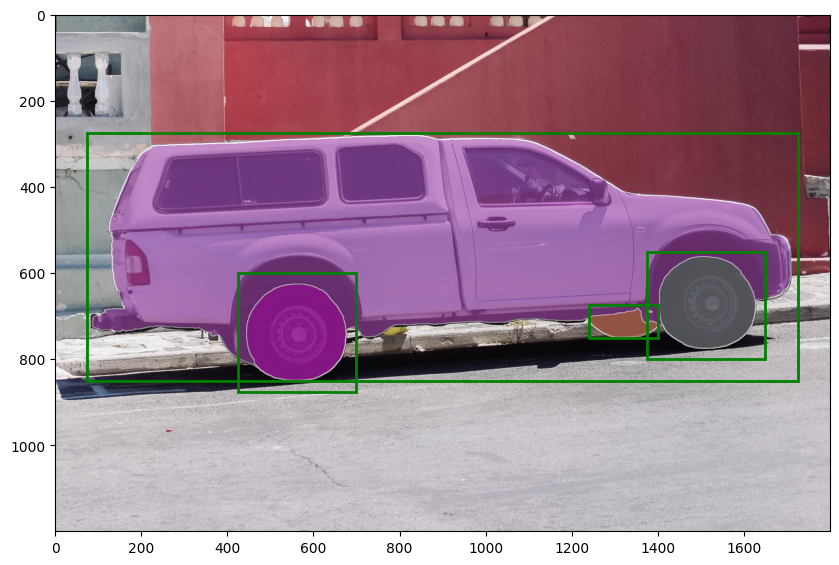

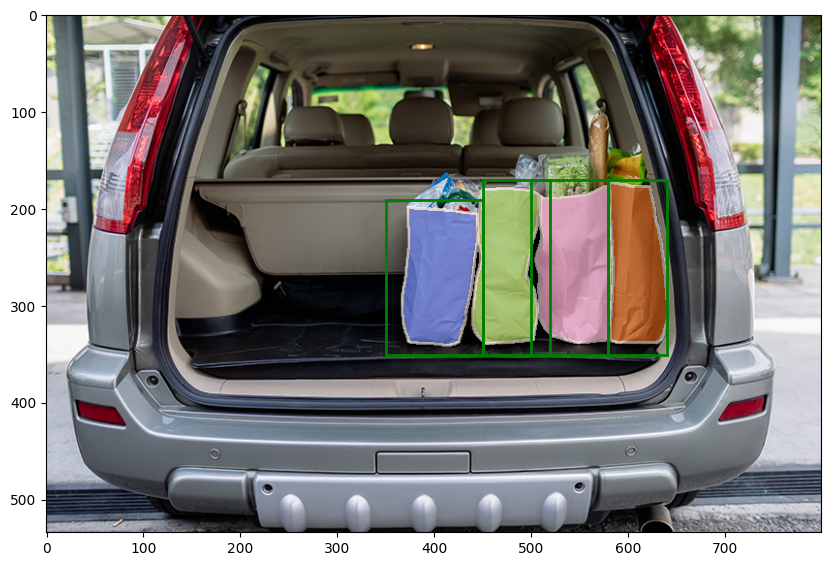

In [82]:
for image, box, masks in zip(image_batch, boxes_batch, masks_batch):
    plot.figure(figsize=(10, 10))
    plot.imshow(image)
    for mask in masks:
        show_mask(mask.squeeze(0), plot.gca(), random_color=True)
    for box in box:
        show_box(box, plot.gca())

Similarly, we can have a batch of point prompts defined over a batch of images

In [83]:
image1_point_coords = np.array(
    [[[500, 375]], [[650, 750]]]
)  # Bx1x2 where B corresponds to number of objects
image1_point_labels = np.array([[1], [1]])

image2_point_coords = np.array(
    [
        [[400, 300]],
        [[630, 300]],
    ]
)
image2_point_labels = np.array([[1], [1]])

point_coords_batch = [image1_point_coords, image2_point_coords]
point_labels_batch = [image1_point_labels, image2_point_labels]

In [84]:
masks_batch, scores_batch, _ = sam2_predictor.predict_batch(
    point_coords_batch=point_coords_batch, point_labels_batch=point_labels_batch, multimask_output=True
)

# Select the best single mask per object
best_masks = []
for masks, scores in zip(masks_batch, scores_batch):
    best_masks.append(masks[range(len(masks)), np.argmax(scores, axis=-1)])

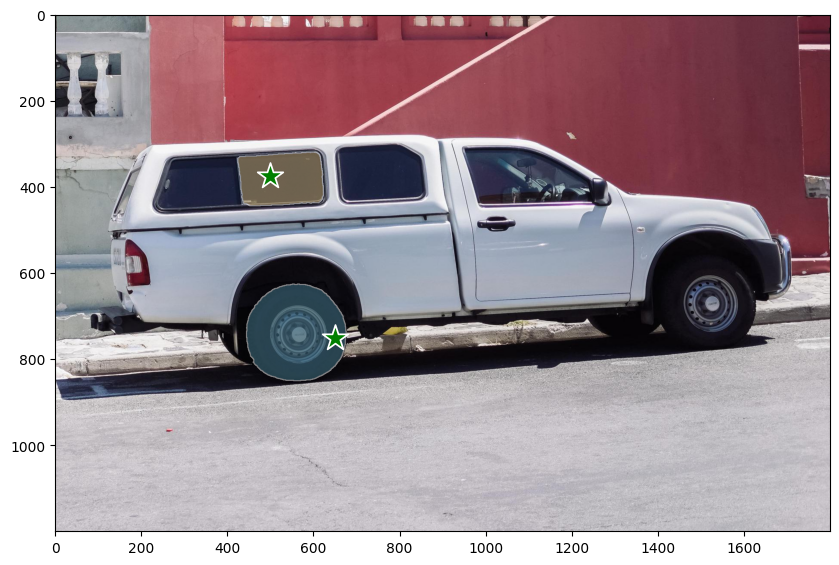

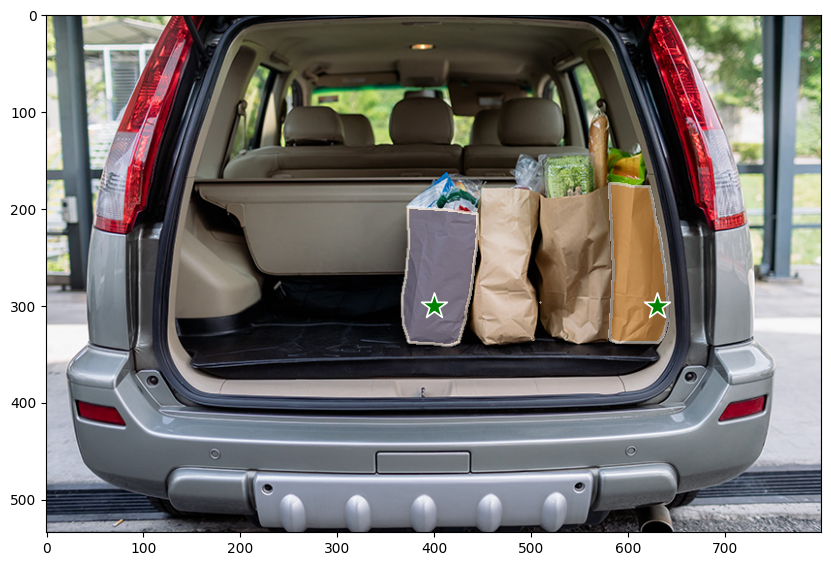

In [85]:
for image, points, labels, masks in zip(image_batch, point_coords_batch, point_labels_batch, best_masks):
    plot.figure(figsize=(10, 10))
    plot.imshow(image)
    for mask in masks:
        show_mask(mask, plot.gca(), random_color=True)
    show_points(points, labels, plot.gca())